In [49]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
options(repr.matrix.max.rows = 6)

In [50]:
players <- read_csv("https://raw.githubusercontent.com/tiffyue/dsci_100_project/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [51]:
# Wrangling dataset to compensate for missing observations in Age
players_data <- players |> 
    mutate(subscribe = as_factor(subscribe)) |>
    filter(!is.na(Age)) |>
    select(subscribe, played_hours, Age)


# mean of all the quantitative data (played_hours and Age)

mean_players <- players_data |>
    select(played_hours, Age) 
    
players_data
mean_players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17


played_hours,Age
<dbl>,<dbl>
30.3,9
3.8,17
0.0,17
⋮,⋮
0.3,22
0.0,17
2.3,17


| Quantitative Player Data  | Mean
|--------------|-----
| played_hours | 5.90
| Age          | 20.5

In [52]:
# splitting the data into training and test datasets 
# 75% is training data, 25% is test data 

players_split <- initial_split(players_data, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

In [53]:
# double check the split of the proportions 

players_proportion <- players_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(players_train))

players_proportion

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


In [54]:
# we need to standardize and center the quantitative data using a recipe 
players_recipe <- recipe(subscribe ~., data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# specify the knn classification model with an arbitrary # of neighbors of k = 3

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# create the 5 fold cross validation  
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# use values from 1 to 100 by 5 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# fit the knn model 
knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

# indicate the accuracy (mean) and its standard error
accuracies <- knn_fit |>
  filter(.metric == "accuracy") 

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4263547,5,0.04276503,Preprocessor1_Model01
6,accuracy,binary,0.5783908,5,0.03070795,Preprocessor1_Model02
11,accuracy,binary,0.7242529,5,0.01830115,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model18
91,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model19
96,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model20


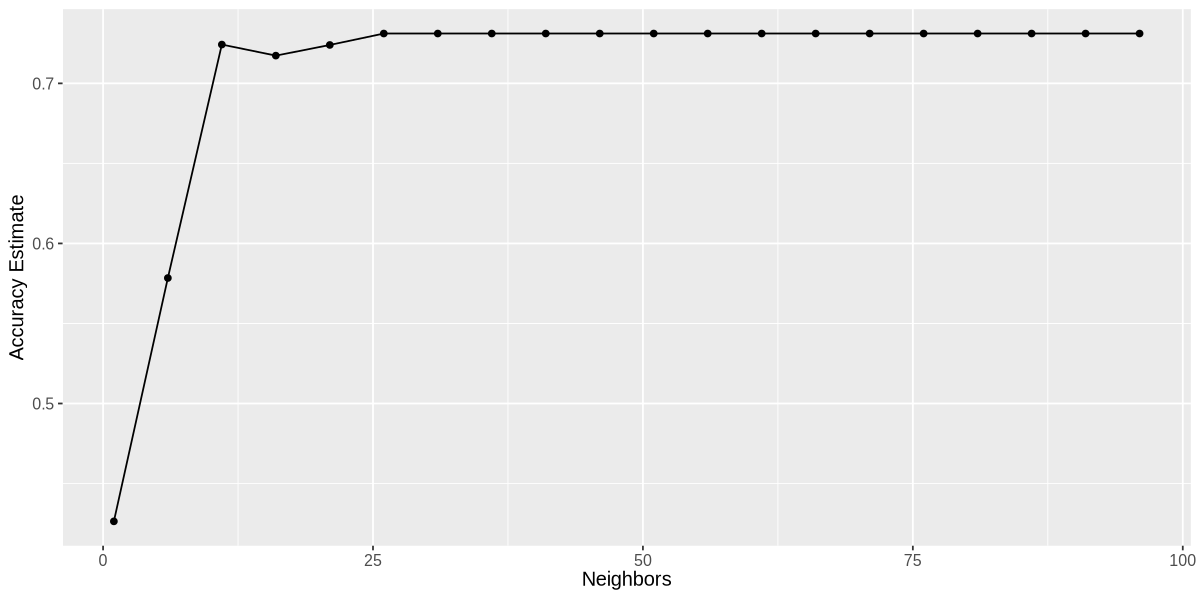

In [55]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [56]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 26

In [57]:
# calculate the new fit with the best k 

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(26,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2689655
Best kernel: rectangular
Best k: 26

In [58]:
# predict with the test data 
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,FALSE,0.0,17
TRUE,TRUE,0.1,21
TRUE,TRUE,0.0,17
⋮,⋮,⋮,⋮
TRUE,FALSE,0.0,17
TRUE,TRUE,32.0,22
TRUE,FALSE,0.3,22


In [59]:
# evaluate the performance of accuracy
players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


In [60]:
# check the order of subscribe 
cancer_test_predictions |> pull(subscribe) |> levels()

[1] "FALSE" "TRUE"

In [61]:
# evaluate the precision 
players_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7346939


In [62]:
# evaluate the recall 
players_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


In [63]:
# create a confusion matrix to evaluate positives (TRUE) and negative (FALSE) 
confusion <- cancer_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     9   16
     TRUE      4   20

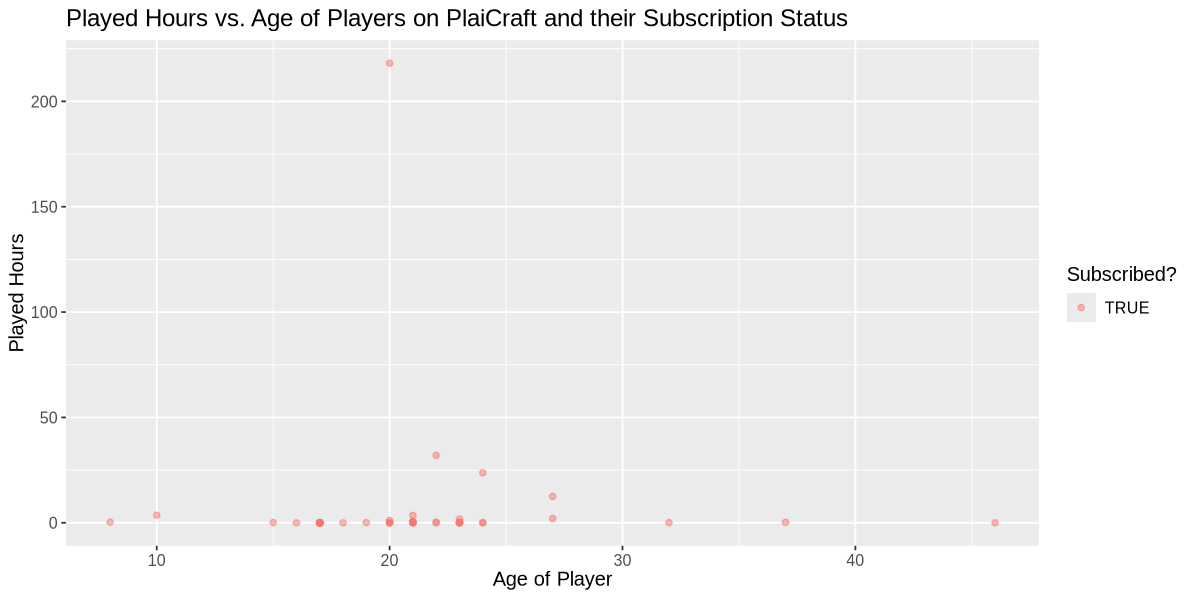

In [64]:
# scatterplot of played_hours vs Age when evaluating .pred class (TRUE oR
options(repr.plot.height = 5, repr.plot.width = 10)
subscribe_plot <- players_test_predictions |>
                    ggplot(aes(x = Age, y = played_hours,
                              color = .pred_class)) +
                    geom_point(alpha = 0.5) + 
                    labs(x = "Age of Player",
                         y = "Played Hours",
                         color = "Subscribed?") +
                    ggtitle("Played Hours vs. Age of Players on PlaiCraft and their Subscription Status") +
                    theme(text = element_text(size = 12))

                         
subscribe_plot